In [1]:
#First try at using a hadronic decay file

In [1]:
import sys 
import os

import numpy as np
import matplotlib.pyplot as plt
import timeit

sys.path.insert(0, '../MATHUSLA_FastSim/')
import DetectorSimulation.Detector as Detector
import DetectorSimulation.llp_gun_new as lg
from Helpers.functions import *

sys.path.insert(0,'../FastSim_Additions/')
from Additions import initiate_detector
from run_simulation import do_sim

sys.path.insert(0, '../MixingAnglePlots/')
from MixingAngle_vs_Yield_Plot import get_ctaus

In [2]:
fv_file = '../SimulationData/RHN_Ue_LLPweight4vectorBmesonlist_mN_0.316228.csv'
fv_path = os.path.join(os.getcwd(), fv_file)
length_file = '../SimulationData/RHNctauUe.dat'
len_path = os.path.join(os.getcwd(), length_file)
product_file = '../SimulationData/vN_to_all_0.314228_hadron_style.txt'
prod_path = os.path.join(os.getcwd(), product_file)

In [3]:
mass = float(fv_file.split('_')[-1][:-4])
mixing = 0.004
ctau = get_ctaus(mass = mass, mixing = mixing)

In [4]:
detector_benchmark = initiate_detector()

In [5]:
start = timeit.default_timer()

vertices = do_sim(fv_path, prod_path, ctau, mass, detector_benchmark, 10000)

end = timeit.default_timer()

print(start - end)

-3.8959643999114633


In [10]:
from Event_Data_Structure import *

In [7]:
data = multi_event_data(vertices)

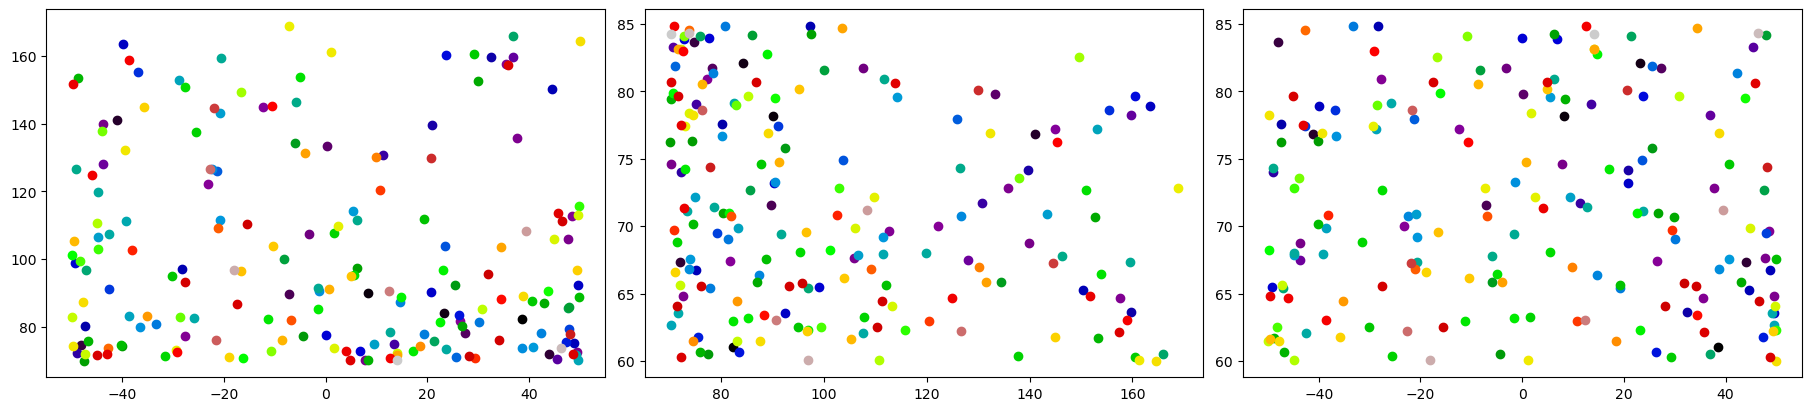

In [8]:
fig, ax = plt.subplots(nrows = 1,ncols = 3, constrained_layout = True, figsize = (6 * 3,4))

colours = plt.cm.nipy_spectral(np.linspace(0,1, len(data[:,0])))

for i, event in enumerate(data[:,0]):
    ax[0].scatter(event[0], event[1], color = colours[i])
    ax[1].scatter(event[1], event[2], color = colours[i])
    ax[2].scatter(event[0], event[2], color = colours[i])


In [9]:
test = vertices[0]

In [10]:
test.particles[0].particle.momentum

array([4.79563469, 1.77080838, 3.61741548, 2.60510442])

In [11]:
better = ak.Array([test.vertex.position,
          test.vertex.momentum,
          np.array([daughter.particle.momentum for daughter in test.particles])])

In [12]:
trying = ak.Array([test.vertex.position, test.vertex.momentum])

In [13]:
def to_dict(llp_vertex):
    return {'position':llp_vertex.vertex.position,
            'momentum':llp_vertex.vertex.momentum,
            'tracks': get_track_information(llp_vertex),
            'recon': llp_vertex.recon_criteria,
            'wall':llp_vertex.wall_hit}

In [14]:
does_dict_work = to_dict(vertices[0])

In [15]:
does_dict_work

{'position': array([38.60299735, 82.25510721, 61.00870123]),
 'momentum': array([10.73664977,  3.78535297,  8.06581447,  5.98242324]),
 'tracks': <Array [[[4.8, 1.77, ..., 2.61], ..., 0], ...] type='3 * var * union[var * ...'>,
 'recon': [],
 'wall': {'LLP_DECAY': True,
  'LLP_DETECTOR': True,
  'DECAY': True,
  'DETECTOR': True}}

In [16]:
daughters = does_dict_work['tracks']

In [17]:
daughters

<Array [[[4.8, 1.77, ..., 2.61], ..., 0], ...] type='3 * var * union[var * ...'>

In [18]:
daughters[:,0]

<Array [[4.8, 1.77, 3.62, 2.61], ..., [...]] type='3 * union[var * float64,...'>

In [20]:
tracks = np.array([np.append(daughter.particle.momentum.flatten(), np.array([daughter.particle.pid, len(daughter.tracker_hits)])) for daughter in vertices[0].particles])

In [21]:
tracks

array([[  4.79563469,   1.77080838,   3.61741548,   2.60510442,
         12.        ,   0.        ],
       [ -3.8096375 ,  -1.18852791,  -2.96075453,  -2.08685366,
         12.        ,   0.        ],
       [  2.79935578,   1.03034267,   2.10569248,   1.53058975,
        -12.        ,   0.        ]])

In [22]:
builder = ak.ArrayBuilder()
for llp_vertex in vertices:
    tracks = np.array([np.append(daughter.particle.momentum, np.array([daughter.particle.pid, len(daughter.tracker_hits)])) for daughter in llp_vertex.particles])
    builder.append(tracks)

In [23]:
awk_array = builder.snapshot()

In [24]:
awk_array[0].to_numpy()

array([[  4.79563469,   1.77080838,   3.61741548,   2.60510442,
         12.        ,   0.        ],
       [ -3.8096375 ,  -1.18852791,  -2.96075453,  -2.08685366,
         12.        ,   0.        ],
       [  2.79935578,   1.03034267,   2.10569248,   1.53058975,
        -12.        ,   0.        ]])

In [25]:
import numba

In [26]:
import timeit

In [8]:
#@numba.jit(nopython = False)
def make_awk(vertices):
    builder = ak.ArrayBuilder()
    for llp_vertex in vertices:
        tracks = np.array([np.append(daughter.particle.momentum, np.array([daughter.particle.pid, len(daughter.tracker_hits)])) for daughter in llp_vertex.particles])
        builder.append(tracks)
        
    return builder.snapshot()

In [11]:
start = timeit.default_timer()

array = make_awk(vertices)

end = timeit.default_timer()

print(end - start)
array

0.07878200011327863


<Array [[[0.939, 0.299, ..., 12, 0], ...], ...] type='1989 * var * var * fl...'>